# Optimization with Atomic Orbital Search (AOS)

## Required Libraries

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from niapy.task import Task
from niapy.algorithms.basic import ArtificialBeeColonyAlgorithm

## Atomic Orbital Search Implementation

In [2]:
# Atomic Orbital Search (AOS) Class
class AtomicOrbitalSearch:
    def __init__(self, cost_function, var_number=2, var_min=-5, var_max=5, max_fes=100000, n_pop=25, layer_number=5, foton_rate=0.1):
        self.cost_function = cost_function
        self.var_number = var_number
        self.var_min = var_min * np.ones(var_number)
        self.var_max = var_max * np.ones(var_number)
        self.max_fes = max_fes
        self.n_pop = n_pop
        self.layer_number = layer_number
        self.foton_rate = foton_rate
        
        # Initialization
        self.pop = np.random.uniform(self.var_min, self.var_max, (n_pop, var_number))
        self.cost = np.array([self.cost_function(ind) for ind in self.pop])
        self.fes = n_pop  # Function Evaluations
        self.best_pop = None
        self.best_cost = float('inf')
        self.best_costs = []
        self.iteration_candidates = []  # To store candidates for plotting

    def run(self):
        # Sort Population
        sorted_indices = np.argsort(self.cost)
        self.pop = self.pop[sorted_indices]
        self.cost = self.cost[sorted_indices]
        self.best_pop = self.pop[0]
        self.best_cost = self.cost[0]
        
        # Main Loop
        iter = 0
        while self.fes < self.max_fes:
            iter += 1
            pop_c = []
            cost_c = []
            self.iteration_candidates.append(np.copy(self.pop))  # Store current candidates
            
            # Create Quantum Layers
            max_lay = np.random.randint(1, self.layer_number + 1)
            nor_disp = np.exp(-np.arange(max_lay) / (max_lay / 6))
            nor_disp /= np.sum(nor_disp)  # Normalize
            nor_disp_cal = np.round(nor_disp * self.n_pop).astype(int)
            lay_col = np.concatenate(([0], np.cumsum(nor_disp_cal)))  # límites de las capas
            lay_col[lay_col > self.n_pop] = self.n_pop  # asegura de que no exceda la población total
            
            # Search Loop
            for i in range(max_lay):
                pop_a = self.pop[lay_col[i]:lay_col[i + 1]]  # soluciones que pertenecen a la capa i
                cost_a = self.cost[lay_col[i]:lay_col[i + 1]]  # coste de soluciones de la capa i
                energy = np.mean(cost_a)  # energía promedio de la capa i
                orbit = i + 1  # Layer index (starting from 1)

                for j in range(len(pop_a)):  # para cada solución (electrón) de la capa i
                    if np.random.rand() > self.foton_rate:  # interacción con fotones
                        if cost_a[j] > energy:
                            ir = np.random.rand(2)
                            jr = np.random.rand(self.var_number)
                            x_old = pop_a[j]
                            x_best = self.best_pop
                            x_mean = np.mean(pop_a, axis=0) if len(pop_a) > 1 else pop_a[0]
                            pop_b = x_old + (jr * (ir[0] * x_best - ir[1] * x_mean) / orbit)
                        else:
                            ir = np.random.rand(2)
                            jr = np.random.rand(self.var_number)
                            x_old = pop_a[j]
                            x_best = pop_a[0]
                            x_mean = np.mean(pop_a, axis=0) if len(pop_a) > 1 else pop_a[0]
                            pop_b = x_old + (jr * (ir[0] * x_best - ir[1] * x_mean))
                    else:
                        pop_b = np.random.uniform(self.var_min, self.var_max, self.var_number)

                    # Apply bounds
                    pop_b = np.clip(pop_b, self.var_min, self.var_max)
                    cost_b = self.cost_function(pop_b)
                    self.fes += 1
                    
                    # Store results
                    pop_c.append(pop_b)
                    cost_c.append(cost_b)

            # Merge Candidates
            self.pop = np.vstack((self.pop, pop_c))
            self.cost = np.concatenate((self.cost, cost_c))

            # Sort Population
            sorted_indices = np.argsort(self.cost)
            self.pop = self.pop[sorted_indices]
            self.cost = self.cost[sorted_indices]
            self.best_pop = self.pop[0]
            self.best_cost = self.cost[0]
            self.best_costs.append(self.best_cost)

            # Truncate population
            self.pop = self.pop[:self.n_pop]
            self.cost = self.cost[:self.n_pop]

            # Show Iteration Information
            # print(f"Iteration {iter}: Best Cost = {self.best_cost}")

        return self.best_pop, self.best_cost, self.best_costs

# Plotting convergence
def plot_convergence(best_costs):
    plt.figure(figsize=(10, 6))
    plt.plot(best_costs, color='blue', linewidth=2)
    plt.title('Convergence Plot')
    plt.xlabel('Iteration')
    plt.ylabel('Best Cost')
    plt.grid(True)
    plt.show()

## Test functions

In [3]:
def test_functions(X, fun_index, dim=None):
    """
    Compute the fitness value for a given input vector `X` and a specific benchmark function.

    Parameters:
    - X: ndarray, Input vector
    - fun_index: int, Index of the function to evaluate
    - dim: int, Dimension of the input vector (default is derived from X if not provided)

    Returns:
    - Fit: float, The fitness value
    """
    if dim is None:
        dim = len(X)

    if fun_index == 1:  # Sphere
        Fit = np.sum(X ** 2)

    elif fun_index == 2:  # Schwefel 1.2
        Fit = sum([np.sum(X[:i + 1]) ** 2 for i in range(dim)])

    elif fun_index == 3:  # Schwefel 2.21
        Fit = np.max(np.abs(X))

    elif fun_index == 4:  # Rosenbrock
        Fit = np.sum(100 * (X[1:] - X[:-1] ** 2) ** 2 + (X[:-1] - 1) ** 2)

    elif fun_index == 5:  # Quartic
        Fit = np.sum(np.arange(1, dim + 1) * (X ** 4)) + np.random.rand()

    elif fun_index == 6:  # Schwefel
        Fit = np.sum(-X * np.sin(np.sqrt(np.abs(X))))

    elif fun_index == 7:  # Rastrigin
        Fit = np.sum(X ** 2 - 10 * np.cos(2 * np.pi * X)) + 10 * dim

    elif fun_index == 8:  # Ackley
        Fit = -20 * np.exp(-0.2 * np.sqrt(np.sum(X ** 2) / dim)) - \
              np.exp(np.sum(np.cos(2 * np.pi * X)) / dim) + 20 + np.e

    elif fun_index == 9:  # Hartman 3
        a = np.array([[3, 10, 30], [0.1, 10, 35], [3, 10, 30], [0.1, 10, 35]])
        c = np.array([1, 1.2, 3, 3.2])
        p = np.array([[0.3689, 0.117, 0.2673], [0.4699, 0.4387, 0.747], [0.1091, 0.8732, 0.5547], [0.03815, 0.5743, 0.8828]])
        Fit = -np.sum([c[i] * np.exp(-np.sum(a[i, :] * (X - p[i, :]) ** 2)) for i in range(4)])

    elif fun_index == 10:  # Hartman 6
        a = np.array([[10, 3, 17, 3.5, 1.7, 8], [0.05, 10, 17, 0.1, 8, 14], [3, 3.5, 1.7, 10, 17, 8],
                    [17, 8, 0.05, 10, 0.1, 14]])
        c = np.array([1, 1.2, 3, 3.2])
        p = np.array([[0.1312, 0.1696, 0.5569, 0.0124, 0.8283, 0.5886],
                    [0.2329, 0.4135, 0.8307, 0.3736, 0.1004, 0.9991],
                    [0.2348, 0.1415, 0.3522, 0.2883, 0.3047, 0.6650],
                    [0.4047, 0.8828, 0.8732, 0.5743, 0.1091, 0.0381]])
        Fit = -np.sum([c[i] * np.exp(-np.sum(a[i, :] * (X - p[i, :]) ** 2)) for i in range(4)])

    elif fun_index == 11:  # Shekel 5, 7, 10
        a = np.array([[4, 4, 4, 4], [1, 1, 1, 1], [8, 8, 8, 8], [6, 6, 6, 6],
                    [3, 7, 3, 7], [2, 9, 2, 9], [5, 5, 3, 3], [8, 1, 8, 1],
                    [6, 2, 6, 2], [7, 3.6, 7, 3.6]])
        c = np.array([0.1, 0.2, 0.2, 0.4, 0.4, 0.6, 0.3, 0.7, 0.5, 0.5])
        m = 5 if fun_index == 21 else (7 if fun_index == 22 else 10)
        Fit = -np.sum([1 / (np.sum((X - a[i, :]) ** 2) + c[i]) for i in range(m)])

    else:
        raise ValueError("Invalid function index.")

    return Fit


def test_functions_range(fun_index):
    """
    Get the range and default dimension for a given benchmark function index.

    Parameters:
    - fun_index: int, Index of the function

    Returns:
    - low: float or ndarray, Lower bound(s) of the input space
    - up: float or ndarray, Upper bound(s) of the input space
    - dim: int, Default dimension
    """
    dim = 30  # Default dimension
    if fun_index == 1:
        low, up = -100, 100
    elif fun_index == 2:
        low, up = -100, 100
    elif fun_index == 3:
        low, up = -100, 100
    elif fun_index == 4:
        low, up = -30, 30
    elif fun_index == 5:
        low, up = -1.28, 1.28
    elif fun_index == 6:
        low, up = -500, 500
    elif fun_index == 7:
        low, up = -5.12, 5.12
    elif fun_index == 8:
        low, up = -32, 32
    elif fun_index == 9:
        low, up = 0, 1
        dim = 3
    elif fun_index == 10:
        low, up = 0, 1
        dim = 6
    elif fun_index == 11:
        low, up = 0, 10
        dim = 4
    else:
        low, up = 0, 10
        dim = 4

    return low, up, dim


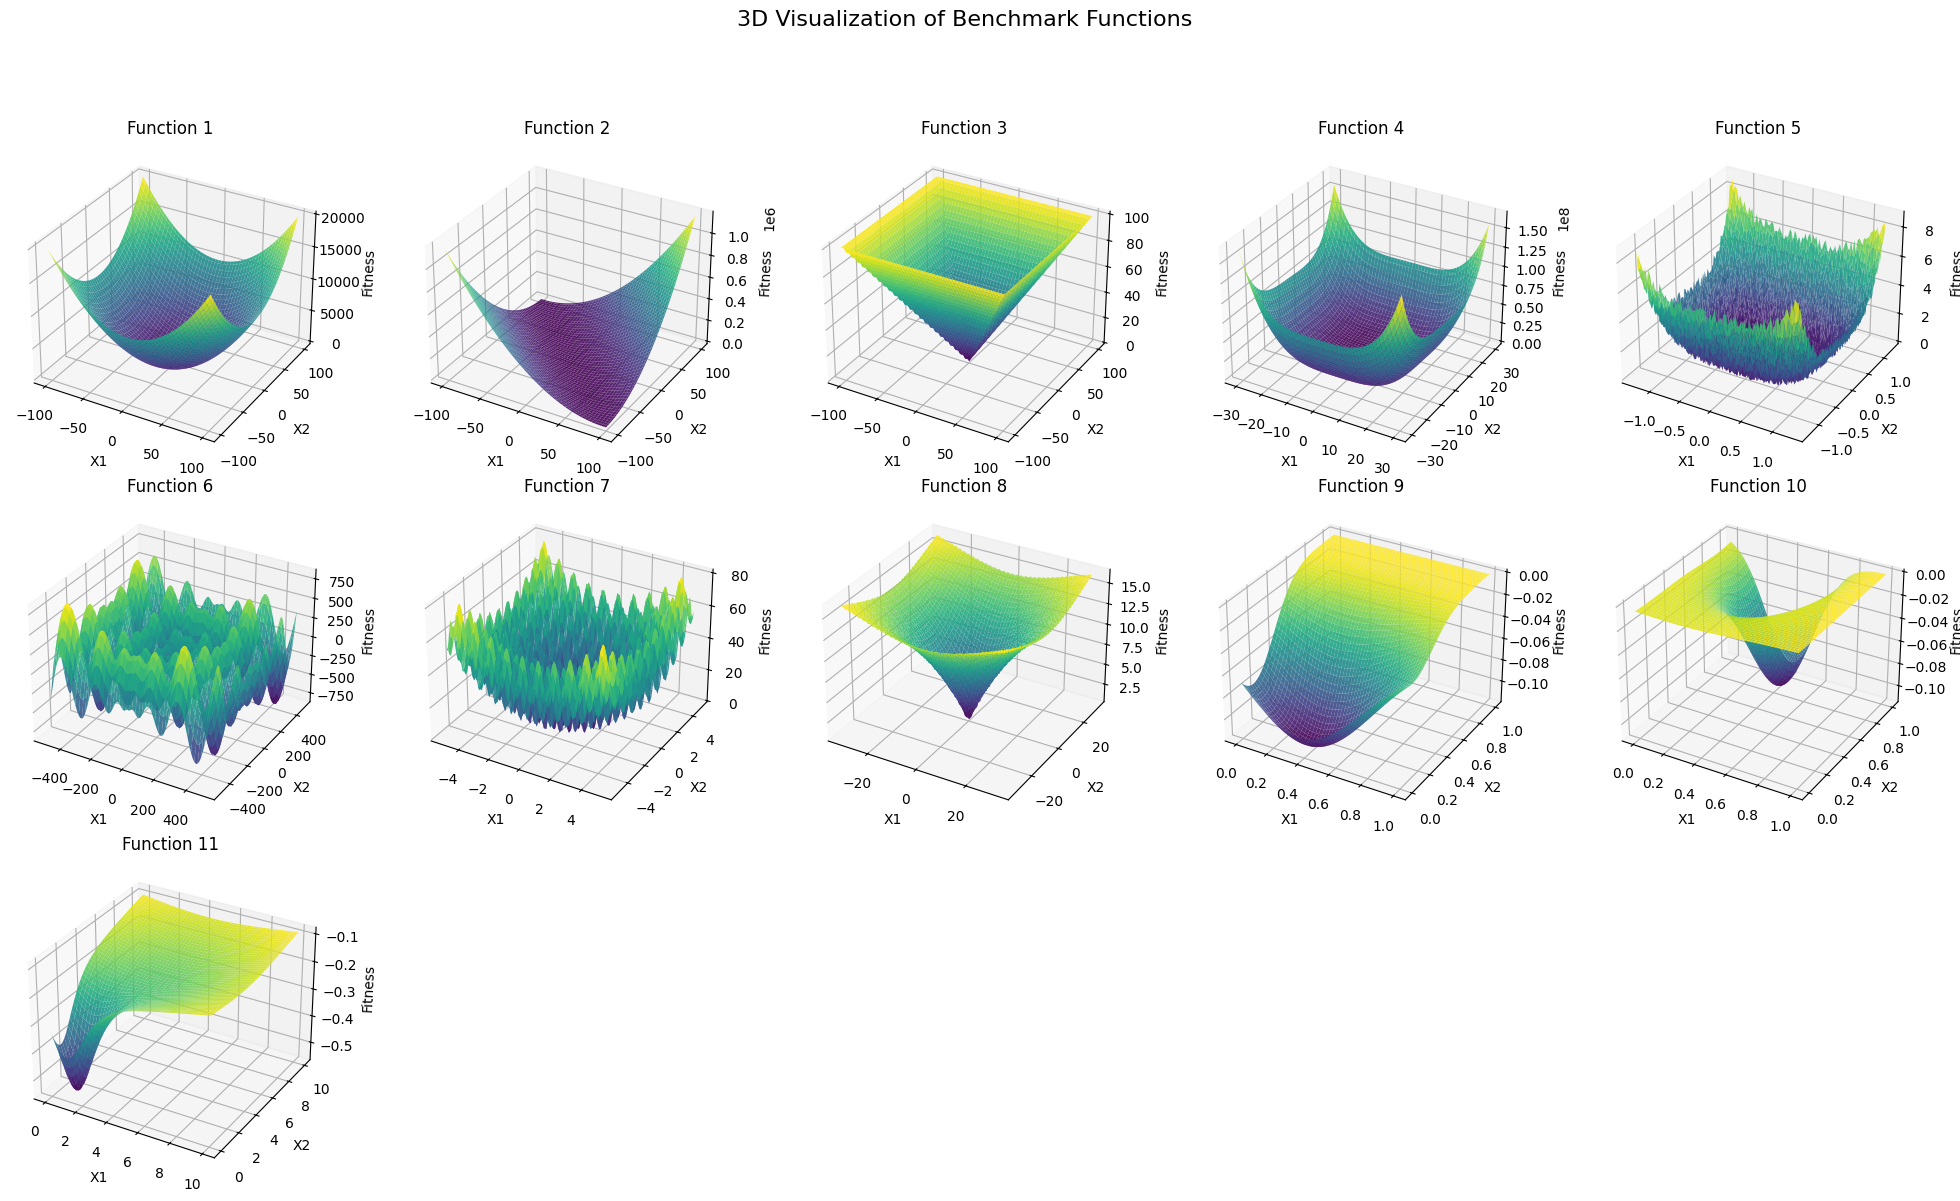

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `test_functions` and `test_functions_range` are defined as above

def plot_functions_in_3d():
    num_functions = 11  # Total number of functions
    rows, cols = 5, 5   # Arrange plots in a grid (adjust rows/cols to fit all functions)
    
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle("3D Visualization of Benchmark Functions", fontsize=16)
    
    for fun_index in range(1, num_functions + 1):
        # Compute subplot position
        ax = fig.add_subplot(rows, cols, fun_index, projection='3d')
        
        # Get range and default dimension for this function
        low, up, dim = test_functions_range(fun_index)
        
        # Set up 2D grid (for visualization, we use the first two dimensions)
        x = np.linspace(low[0] if isinstance(low, np.ndarray) else low,
                        up[0] if isinstance(up, np.ndarray) else up, 100)
        y = np.linspace(low[1] if isinstance(low, np.ndarray) and len(low) > 1 else low,
                        up[1] if isinstance(up, np.ndarray) and len(up) > 1 else up, 100)
        X, Y = np.meshgrid(x, y)
        
        # Flatten grid and prepare inputs for the function
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                point = np.zeros(dim)
                point[0] = X[i, j]
                if dim > 1:
                    point[1] = Y[i, j]
                Z[i, j] = test_functions(point, fun_index, dim)
        
        # Plot the 3D surface
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
        ax.set_title(f"Function {fun_index}")
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.set_zlabel("Fitness")
        #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the 3D plotting function
plot_functions_in_3d()


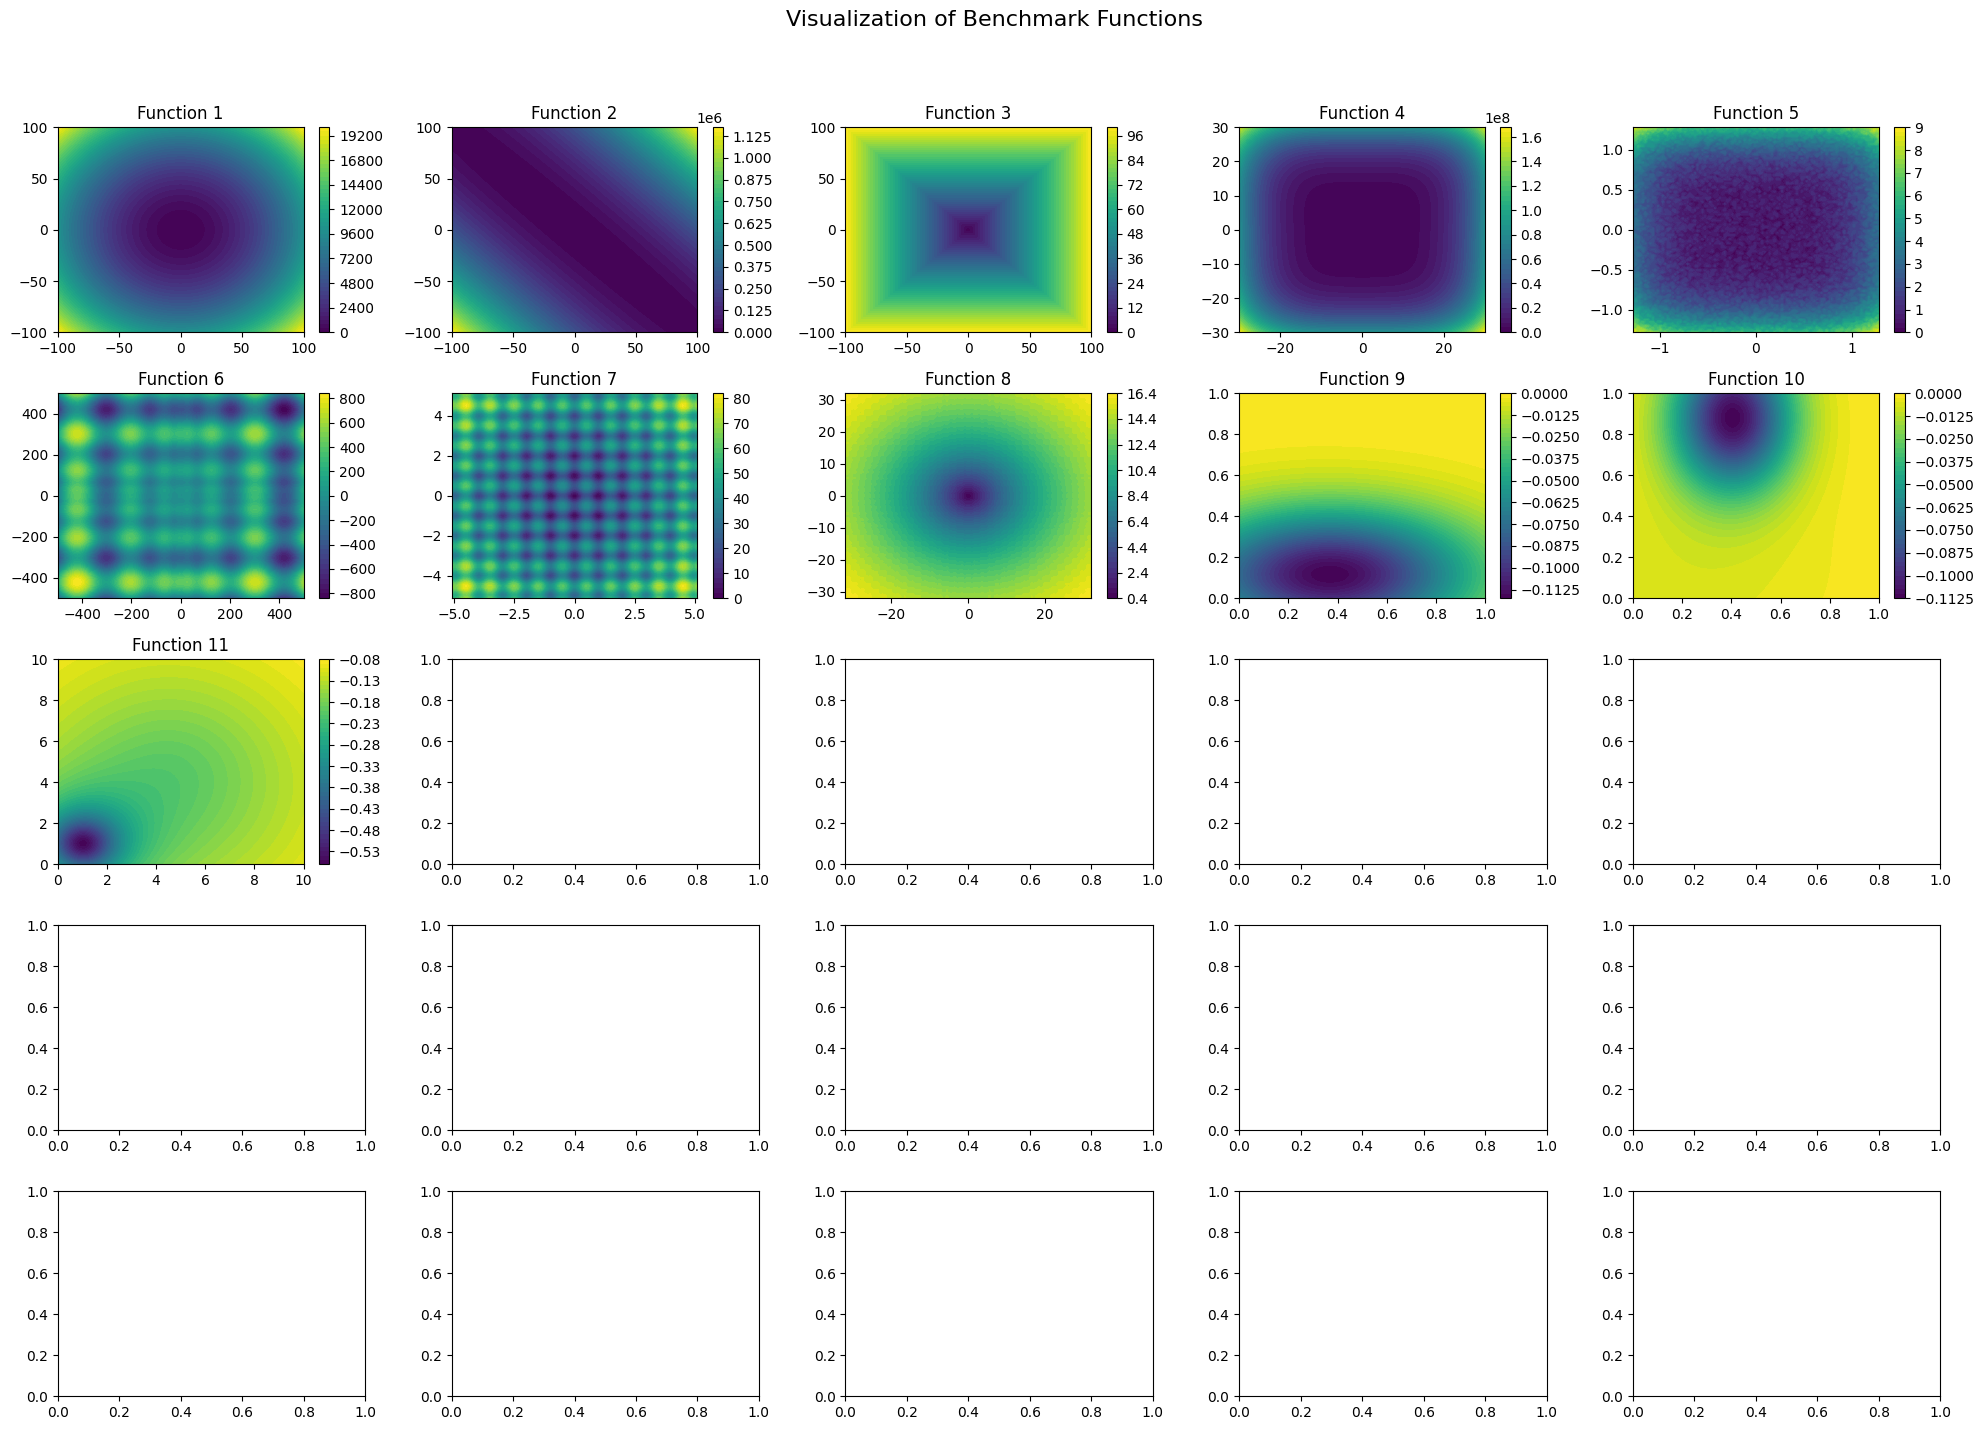

In [5]:
def plot_functions_in_grid():
    num_functions = 11  # Total number of functions
    rows, cols = 5, 5   # Arrange plots in a grid (adjust rows/cols to fit all functions)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    fig.suptitle("Visualization of Benchmark Functions", fontsize=16)
    
    for fun_index in range(1, num_functions + 1):
        row, col = divmod(fun_index - 1, cols)  # Compute subplot position
        ax = axes[row, col]
        
        # Get range and default dimension for this function
        low, up, dim = test_functions_range(fun_index)
        
        # Set up 2D grid (for visualization, we use the first two dimensions)
        x = np.linspace(low[0] if isinstance(low, np.ndarray) else low,
                        up[0] if isinstance(up, np.ndarray) else up, 100)
        y = np.linspace(low[1] if isinstance(low, np.ndarray) and len(low) > 1 else low,
                        up[1] if isinstance(up, np.ndarray) and len(up) > 1 else up, 100)
        X, Y = np.meshgrid(x, y)
        
        # Flatten grid and prepare inputs for the function
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                point = np.zeros(dim)
                point[0] = X[i, j]
                if dim > 1:
                    point[1] = Y[i, j]
                Z[i, j] = test_functions(point, fun_index, dim)
        
        # Plot the function
        c = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
        ax.set_title(f"Function {fun_index}")
        ax.axis('tight')
        fig.colorbar(c, ax=ax, orientation='vertical')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the plotting function
plot_functions_in_grid()


## Parameter optimization using ABC

### AOS

In [6]:
import numpy as np

def select_test_function(fun_index):
    """
    Selects a test function and its parameter ranges by index.

    Parameters:
    - fun_index: int, Index of the benchmark function.

    Returns:
    - function: Callable, The benchmark function.
    - low: float or ndarray, Lower bound(s) of the input space.
    - up: float or ndarray, Upper bound(s) of the input space.
    - dim: int, Default dimension of the input space.
    """
    # Get the parameter ranges and dimensions for the selected function
    low, up, dim = test_functions_range(fun_index)

    # Define the function to use
    def function(X):
        return test_functions(X, fun_index, dim)

    return function, low, up, dim


In [7]:
def aos_objective(params, fun_index):
    """
    Objective function to evaluate AOS performance with given parameters.

    Parameters:
    - params: List of AOS parameters [n_pop, layer_number, foton_rate].

    Returns:
    - best_cost: The best cost achieved by AOS with the given parameters.
    """
    n_pop = int(params[0])        # Population size
    layer_number = int(params[1]) # Number of quantum layers
    foton_rate = params[2]        # Photon interaction rate

    # Test function setup
    function, var_min, var_max, var_number = select_test_function(fun_index)

    # Instantiate and run AOS
    aos = AtomicOrbitalSearch(
        cost_function=function,
        var_number=var_number,
        var_min=var_min,
        var_max=var_max,
        max_fes=10000,
        n_pop=n_pop,
        layer_number=layer_number,
        foton_rate=foton_rate
    )
    _, best_cost, _ = aos.run()

    return best_cost  # Return the best cost as the objective value


In [8]:
from niapy.task import Task
from niapy.problems import Problem
from niapy.algorithms.basic import ArtificialBeeColonyAlgorithm

# Define the problem class for AOS parameter optimization
class AOSParamOptimization(Problem):
    def __init__(self, fun_index):
        # Define the dimension (3 parameters: n_pop, layer_number, foton_rate)
        # and bounds for each parameter
        super().__init__(dimension=3, lower=[10, 1, 0.01], upper=[100, 10, 0.5])
        self.fun_index = fun_index

    def _evaluate(self, x):
        # Call the AOS objective function
        return aos_objective(x, self.fun_index)
    
fun_index = 2  # Select the benchmark function to optimize

# Create a task for the ABC algorithm
task = Task(problem=AOSParamOptimization(fun_index), max_evals=50)  # Set maximum evaluations

# Initialize and run the ABC algorithm
abc = ArtificialBeeColonyAlgorithm(population_size=20)
best_params, best_cost = abc.run(task=task)

print(f"Optimized Parameters: {best_params}")
print(f"Best Cost Achieved: {best_cost}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimized Parameters: [10.          1.          0.22710389]
Best Cost Achieved: 1.5351689615000052e-73


Validated Best Cost: 28.863350893261774


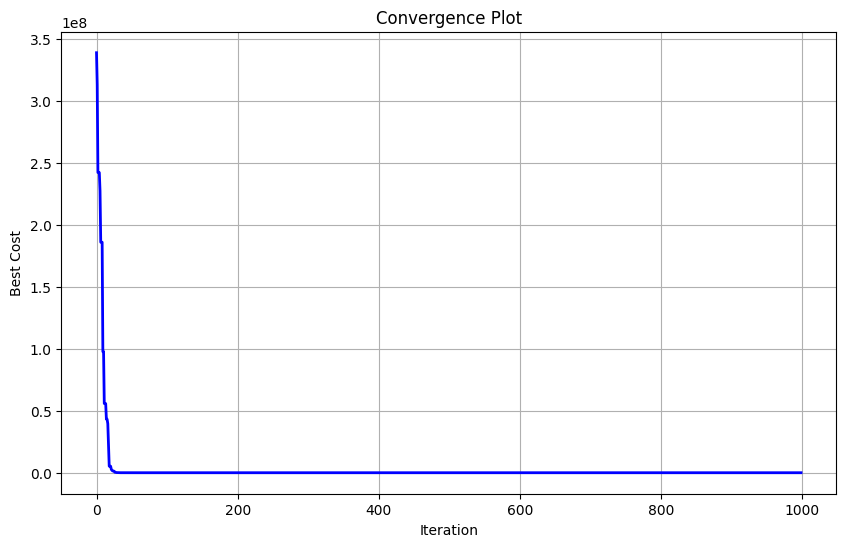

In [11]:
n_pop, layer_number, foton_rate = int(best_params[0]), int(best_params[1]), best_params[2]
fun_index = 4  # Example: Rastrigin function
# Validate AOS with optimized parameters
function, var_min, var_max, var_number = select_test_function(fun_index)
aos = AtomicOrbitalSearch(
    cost_function=function,
    var_number=var_number,
    var_min=var_min,
    var_max=var_max,
    max_fes=10000,
    n_pop=n_pop,
    layer_number=layer_number,
    foton_rate=foton_rate
)
best_solution, best_cost, best_costs = aos.run()

print(f"Validated Best Cost: {best_cost}")
plot_convergence(best_costs)  # Plot convergence if needed


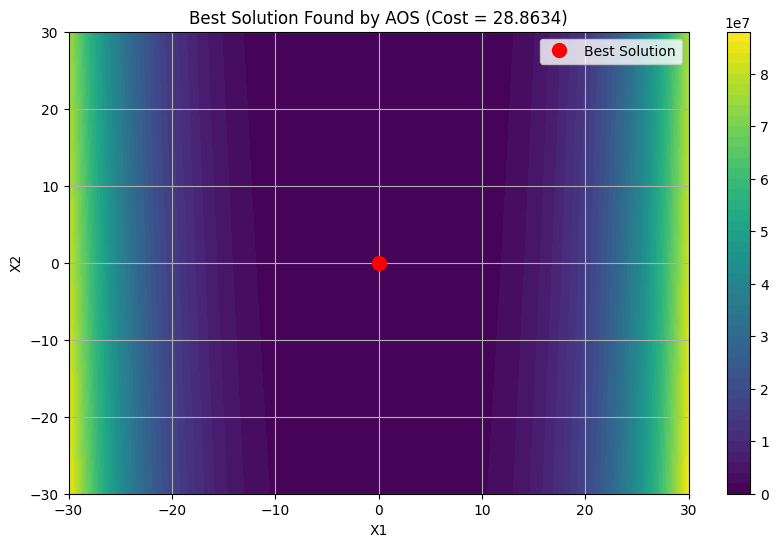

In [12]:
# Show the best solution found by AOS in a 2D plot
def plot_solution_2d(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by AOS (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function
plot_solution_2d(best_solution, best_cost)

### PSO

In [13]:
from niapy.problems import Problem
from pyswarms.single.global_best import GlobalBestPSO

In [14]:
def pso_objective(params, fun_index):
    """
    Objective function to evaluate PSO performance with given parameters.

    Parameters:
    - params: List of PSO parameters [n_particles, inertia, cognitive, social].

    Returns:
    - best_cost: The best cost achieved by PSO with the given parameters.
    """
    n_particles = int(params[0])   # Number of particles
    inertia = params[1]            # Inertia weight
    cognitive = params[2]          # Cognitive coefficient (c1)
    social = params[3]             # Social coefficient (c2)

    # Test function setup
    function, var_min, var_max, var_number = select_test_function(fun_index)

    # Ensure var_min and var_max are arrays
    var_min = np.full(var_number, var_min) if np.isscalar(var_min) else var_min
    var_max = np.full(var_number, var_max) if np.isscalar(var_max) else var_max

    # Instantiate and run PSO
    optimizer = GlobalBestPSO(
        n_particles=n_particles,
        dimensions=var_number,
        options={'c1': cognitive, 'c2': social, 'w': inertia},
        bounds=(var_min, var_max),
    )

    # Suppress output messages by setting verbose=False
    best_cost, _ = optimizer.optimize(function, iters=100, verbose=False)
    
    return best_cost  # Return the best cost as the objective value

In [17]:
class PSOParamOptimization(Problem):
    def __init__(self, fun_index):
        # Dimension should match the number of PSO parameters
        super().__init__(dimension=4, lower=[10, 0.1, 0.1, 0.1], upper=[100, 1.0, 1.0, 1.0])
        self.fun_index = fun_index

    def _evaluate(self, x):
        # Ensure the parameters are within bounds
        if any(x < self.lower) or any(x > self.upper):
            return float('inf')  # Penalize out-of-bounds solutions
        return pso_objective(x, self.fun_index)

fun_index = 4  # Select the benchmark function to optimize
    
# Create a task for the PSO parameter optimization
task_pso = Task(problem=PSOParamOptimization(fun_index), max_evals=50)  # Set maximum evaluations

# Initialize and run the ABC algorithm for PSO
abc_pso = ArtificialBeeColonyAlgorithm(population_size=20)
best_params_pso, best_cost_pso = abc_pso.run(task=task_pso)

print(f"Optimized PSO Parameters: {best_params_pso}")
print(f"Best Cost Achieved by PSO: {best_cost_pso}")

Optimized PSO Parameters: [19.97054617  0.23990484  0.93284445  0.61870207]
Best Cost Achieved by PSO: 3058106401.4629726


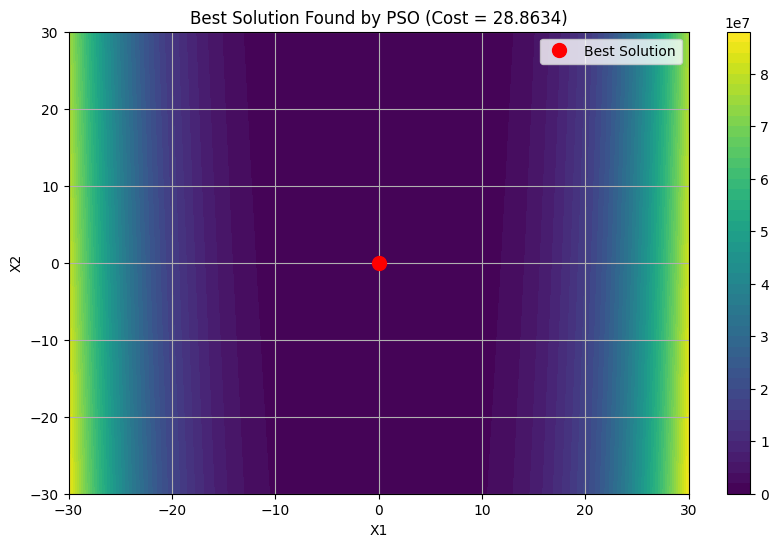

In [18]:
# Plot the best solution found by PSO in a 2D plot

def plot_solution_2d_pso(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by PSO (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function for PSO
plot_solution_2d_pso(best_solution, best_cost)

### GA

In [19]:
from niapy.problems import Problem
from geneticalgorithm import geneticalgorithm as ga

In [20]:
def ga_objective(params, fun_index):
    """
    Objective function to evaluate GA performance with given parameters.

    Parameters:
    - params: List of GA parameters [max_num_iterations, population_size, crossover_rate, mutation_rate].

    Returns:
    - best_cost: The best cost achieved by GA with the given parameters.
    """
    max_num_iterations = int(params[0])  # Maximum number of iterations
    population_size = int(params[1])     # Population size
    crossover_rate = params[2]           # Crossover rate
    mutation_rate = params[3]            # Mutation rate

    # Test function setup
    function, var_min, var_max, var_number = select_test_function(fun_index)

    # Set GA algorithm parameters
    varbound = np.array([[var_min, var_max]] * var_number)  # Bounds for each parameter
    algorithm_params = {
        "max_num_iteration": max_num_iterations,
        "population_size": population_size,
        "mutation_probability": mutation_rate,
        "elit_ratio": 0.01,
        "crossover_probability": crossover_rate,
        "parents_portion": 0.3,
        "crossover_type": "uniform",
        "max_iteration_without_improv": None
    }
    
    # Initialize the GA algorithm
    ga_model = ga(
        function=function,
        dimension=var_number,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_params,
        convergence_curve=False,  # Suppress convergence curve
        progress_bar=False
    )
    
    # Temporarily redirect stdout to suppress all output
    ga_model.run()

    # Get the best cost
    best_cost = ga_model.output_dict['function']  # Extract the best cost
    return best_cost  # Return the best cost as the objective value



In [21]:
class GAParamOptimization(Problem):
    def __init__(self, fun_index):
        # Define the dimension (3 parameters: max_num_iteration, population_size, crossover_rate, mutation_rate)
        super().__init__(dimension=4, lower=[10, 10, 0.1, 0.1], upper=[100, 100, 1.0, 1.0])
        self.fun_index = fun_index

    def _evaluate(self, x):
        # Call the GA objective function
        return ga_objective(x, self.fun_index)
    
# Create a task for the GA parameter optimization
task_ga = Task(problem=GAParamOptimization(fun_index), max_evals=50)  # Set maximum evaluations

# Initialize and run the ABC algorithm for GA
abc_ga = ArtificialBeeColonyAlgorithm(population_size=20)
best_params_ga, best_cost_ga = abc_ga.run(task=task_ga)

print(f"Optimized GA Parameters: {best_params_ga}")
print(f"Best Cost Achieved by GA: {best_cost_ga}")

 The best solution found:
 [  0.91619201   4.47943271 -12.0563155  -11.9263713    4.54417323
   0.77504371  -9.08766654  11.86145445   2.72469082 -12.36530063
   5.68258163  -3.12006494  -5.6994663    6.12571291  -0.63984945
 -13.41378873  -2.94827527   6.59915855  -5.34261977   4.73950149
  -6.81081702   6.76553635   4.34063874  -5.40314392  -2.83316693
  -5.64139286   1.33545049   8.44421229  -4.75072663 -11.71862817]

 Objective function:
 14546616.154873691
 The best solution found:
 [  6.96570358  -1.29393746  -6.72828777  -3.29475345   7.71695703
  -9.05460966  10.46301307   7.73067311  17.78491865   1.57513017
  -1.33187879   6.25873594  18.82103256  -7.35117894  -1.660401
  -1.16269398  15.38876355 -11.55238449   1.94019025   7.33753361
   8.52876865  -0.39841098  -4.47809158   2.26512981   7.10140161
   5.61027155 -12.98553874   0.33291306  -8.64249721  24.44966578]

 Objective function:
 38208389.39173753
 The best solution found:
 [-5.97859062  0.4236994   1.60679842 -6.6777

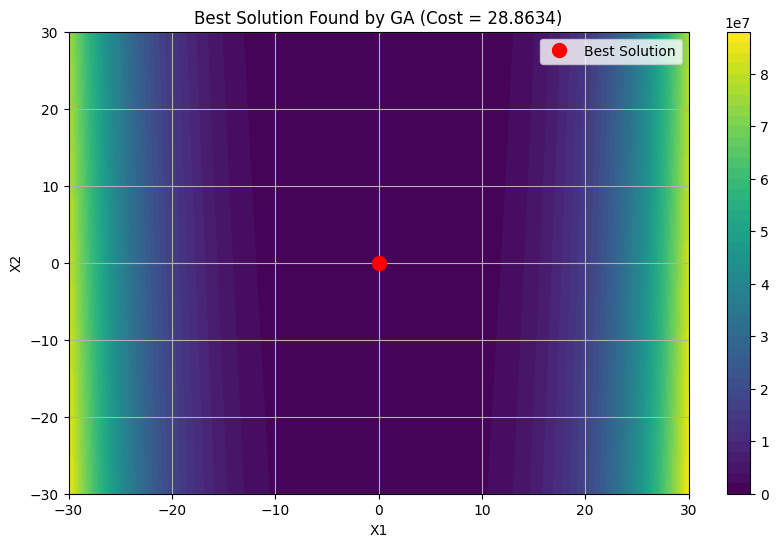

In [22]:
# Plot the best solution found by GA in a 2D plot

def plot_solution_2d_ga(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by GA (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function for GA
plot_solution_2d_ga(best_solution, best_cost)

## Comparing the metaheuristics

In [23]:
n_runs = 5  # Number of runs for each algorithm
results = {'AOS': [], 'PSO': [], 'GA': []}
times = {'AOS': [], 'PSO': [], 'GA': []}
convergences = {'AOS': [], 'PSO': [], 'GA': []}
# All function indices to test
function_indices = 11

for fun_index in range(1, function_indices + 1):
    function, var_min, var_max, var_number = select_test_function(fun_index)
    print(f"Function {fun_index}: {function.__name__} (Dimension: {var_number})")

    # AOS parameter optimization
    task_aos = Task(problem=AOSParamOptimization(fun_index), max_evals=50)
    abc_aos = ArtificialBeeColonyAlgorithm(population_size=20)
    best_params_aos, best_cost_aos = abc_aos.run(task=task_aos)

    # PSO parameter optimization
    task_pso = Task(problem=PSOParamOptimization(fun_index), max_evals=50)
    abc_pso = ArtificialBeeColonyAlgorithm(population_size=20)
    best_params_pso, best_cost_pso = abc_pso.run(task=task_pso)

    # GA parameter optimization
    task_ga = Task(problem=GAParamOptimization(fun_index), max_evals=50)
    abc_ga = ArtificialBeeColonyAlgorithm(population_size=20)
    best_params_ga, best_cost_ga = abc_ga.run(task=task_ga)

    # Run each algorithm with the optimized parameters
    for run in range(n_runs):
        # AOS
        start_time = time.time()
        aos = AtomicOrbitalSearch(
            cost_function=function,
            var_number=var_number,
            var_min=var_min,
            var_max=var_max,
            max_fes=10000,
            n_pop=int(best_params_aos[0]),
            layer_number=int(best_params_aos[1]),
            foton_rate=best_params_aos[2]
        )
        _, best_cost_aos, best_costs_aos = aos.run()
        end_time = time.time()
        results['AOS'].append(best_cost_aos)
        times['AOS'].append(end_time - start_time)
        convergences['AOS'].append(best_costs_aos)

        # PSO
        start_time = time.time()
        var_min_array = np.full(var_number, var_min) if np.isscalar(var_min) else np.array(var_min)
        var_max_array = np.full(var_number, var_max) if np.isscalar(var_max) else np.array(var_max)
        optimizer = GlobalBestPSO(n_particles=int(best_params_pso[0]), dimensions=var_number,
                                  options={'c1': best_params_pso[2], 'c2': best_params_pso[3], 'w': best_params_pso[1]},
                                  bounds=(var_min_array, var_max_array))
        best_cost_pso, best_costs_pso = optimizer.optimize(function, iters=100, verbose=False)
        end_time = time.time()
        results['PSO'].append(best_cost_pso)
        times['PSO'].append(end_time - start_time)
        convergences['PSO'].append(best_costs_pso)

        # GA
        start_time = time.time()
        varbound = np.array([[var_min, var_max]] * var_number)
        algorithm_params = {
            "max_num_iteration": int(best_params_ga[0]),
            "population_size": int(best_params_ga[1]),
            "mutation_probability": best_params_ga[3],
            "elit_ratio": 0.01,
            "crossover_probability": best_params_ga[2],
            "parents_portion": 0.3,
            "crossover_type": "uniform",
            "max_iteration_without_improv": None}
        ga_model = ga(function=function, dimension=var_number, variable_type='real', 
                      variable_boundaries=varbound, algorithm_parameters=algorithm_params, convergence_curve=False, progress_bar=False)
        ga_model.run()
        end_time = time.time()
        best_cost_ga = ga_model.output_dict['function']
        results['GA'].append(best_cost_ga)
        times['GA'].append(end_time - start_time)
        convergences['GA'].append(ga_model.report)

Function 1: function (Dimension: 30)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 The best solution found:
 [ -8.95628255  -0.89701419  -1.59613994   8.85863262  21.77816891
   9.27730479 -26.88659756  25.43181978 -17.87123476   8.41910882
  24.59955929   4.85935618 -12.56409825   0.39852623  -9.61428215
  -5.44335244   7.6461388  -12.4803133    8.73999063  -4.63013179
  20.5377129    3.01930875  11.60356155 -11.88137892 -14.33402991
  15.88428221  19.01700535  -9.52729982  12.19083098  18.25695647]

 Objective function:
 5802.054743657483
 The best solution found:
 [ -0.46506471 -19.16104252 -42.45681334   5.5648469  -16.58388257
 -23.91034693  -6.13168347 -45.68773093   5.49287908  -4.79511311
  42.74170903  -3.45789638  -7.92633198  24.99339003  11.8292677
  29.53590821 -18.40844814 -48.58469534 -50.56266188  12.04379904
   1.48038393 -32.52557818 -19.15139289 -28.22767289 -16.39050759
 -51.05559608 -16.51629431 -10.81055336  58.75472728 -31.91281913]

 Objective function:
 24124.566076101142
 The best solution found:
 [-11.02575973 -19.18195878  -4.21390308 -21

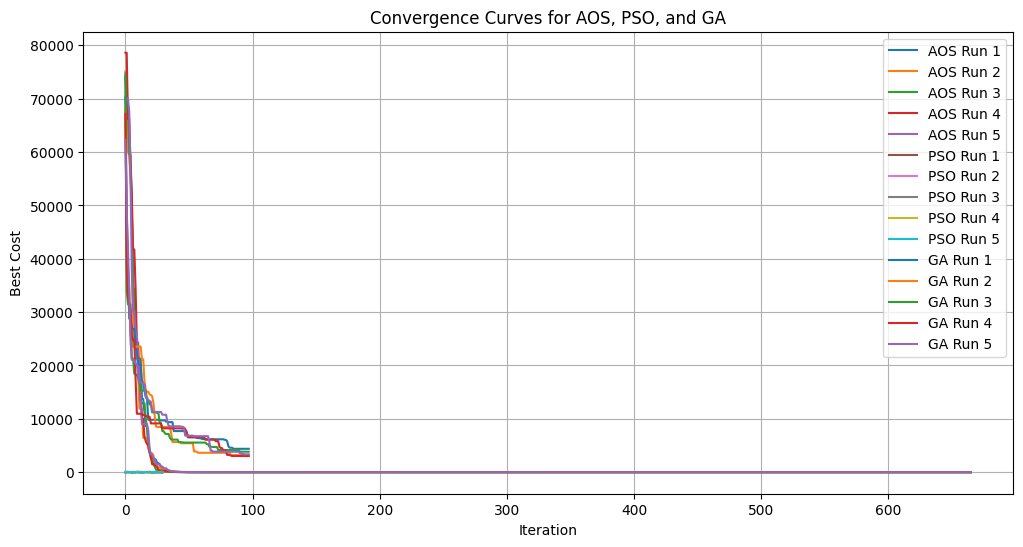

In [25]:
# Plot convergence curves for each algorithm
plt.figure(figsize=(12, 6))
for algo in ['AOS', 'PSO', 'GA']:
    for i in range(5):
        plt.plot(convergences[algo][i], label=f'{algo} Run {i+1}')
plt.title('Convergence Curves for AOS, PSO, and GA')
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
import pandas as pd
import numpy as np

# Example: Theoretical optimal solutions for each function (replace with actual values)
optimal_solutions = {
    1: 0.0,  # Sphere Function
    2: 0.0,  # Schwefel 1.2
    3: 0.0,  # Schwefel 2.21
    4: 0.0,  # Rosenbrock (Optimal fitness value is 0.0 for X=1)
    5: 0.0,  # Quartic Function with Noise (ignoring noise)
    6: -418.9829,  # Schwefel Function (dimension-dependent, replace `n` with the dimension)
    7: 0.0,  # Rastrigin Function
    8: 0.0,  # Ackley Function
    9: -3.86278,  # Hartman 3
    10: -3.32237,  # Hartman 6
    11: -10.536  # Shekel Function (Shekel 10)
}

# Placeholder for the table data
table_data = []

# Tolerance for determining whether a solution is optimal
tolerance = 0.001

for fun_index in range(1, function_indices + 1):
    optimal_solution = optimal_solutions[fun_index]
    row = {"Function": fun_index}

    for algorithm in ['GA', 'PSO', 'AOS']:
        # Get results and times for the current function
        func_results = results[algorithm][(fun_index - 1) * n_runs: fun_index * n_runs]
        func_times = times[algorithm][(fun_index - 1) * n_runs: fun_index * n_runs]

        # Count how many times the optimal solution is found
        optimal_count = sum(1 for result in func_results if abs(result - optimal_solution) <= tolerance)

        # Compute mean time, mean fitness, and best fitness
        mean_time = np.mean(func_times)
        mean_fitness = np.mean(func_results)
        best_fitness = np.min(func_results)

        # Add algorithm details to the row
        row[f"{algorithm}_MeanTime"] = round(mean_time, 4)
        row[f"{algorithm}_MeanFitness"] = round(mean_fitness, 4)
        row[f"{algorithm}_BestFitness"] = round(best_fitness, 4)
        row[f"{algorithm}_OptimalCount"] = optimal_count

    table_data.append(row)

# Create a DataFrame for display
columns = ["Function", 
           "GA_MeanTime", "GA_MeanFitness", "GA_BestFitness", "GA_OptimalCount",
           "PSO_MeanTime", "PSO_MeanFitness", "PSO_BestFitness", "PSO_OptimalCount",
           "AOS_MeanTime", "AOS_MeanFitness", "AOS_BestFitness", "AOS_OptimalCount"]

df = pd.DataFrame(table_data, columns=columns)

# Save the results to a CSV file
df.to_csv('results.csv', index=False)


In [58]:
df

,Function,GA_MeanTime,GA_MeanFitness,GA_BestFitness,GA_OptimalCount,PSO_MeanTime,PSO_MeanFitness,PSO_BestFitness,PSO_OptimalCount,AOS_MeanTime,AOS_MeanFitness,AOS_BestFitness,AOS_OptimalCount
0,1,0.5771,3.557159e+03,3020.7669,0,0.0188,6.561133e+05,5.662346e+05,0,0.4642,0.0000,0.0000,5
1,2,0.7111,2.724735e+04,24643.6429,0,0.0415,1.902682e+07,4.107675e+06,0,1.8676,0.0000,0.0000,5
2,3,1.4233,2.923910e+01,22.2939,0,0.0290,9.608720e+01,9.125620e+01,0,0.4198,0.0000,0.0000,5
3,4,1.0730,1.469317e+06,639562.8880,0,0.0209,3.316468e+09,2.712435e+09,0,0.4667,28.5911,27.8629,0
4,5,0.8496,1.013400e+00,0.5097,0,0.0245,1.523839e+03,8.211185e+02,0,0.5131,0.0019,0.0008,1
5,6,0.4415,-8.122477e+03,-8480.7157,0,0.0402,-3.881335e+04,-8.900164e+04,0,0.5180,-5796.0157,-7268.4360,0
6,7,0.8508,1.502634e+02,110.7768,0,0.0209,1.750578e+03,1.620145e+03,0,0.5353,35.2220,0.0000,3
7,8,1.1305,1.527910e+01,14.3322,0,0.0347,-2.934195e+03,-9.377223e+03,0,0.6539,0.0000,0.0000,5
8,9,1.1130,-3.862500e+00,-3.8628,5,0.0246,-1.102000e-01,-4.351000e-01,0,0.8233,-3.8621,-3.8628,4
9,10,1.0837,-3.253200e+00,-3.2982,0,0.0257,-0.000000e+00,-1.000000e-04,0,0.8953,-3.2162,-3.3194,0


/var/folders/k8/pm7rdrpx1tx44znvg04hlryc0000gn/T/ipykernel_44937/3031445474.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys())


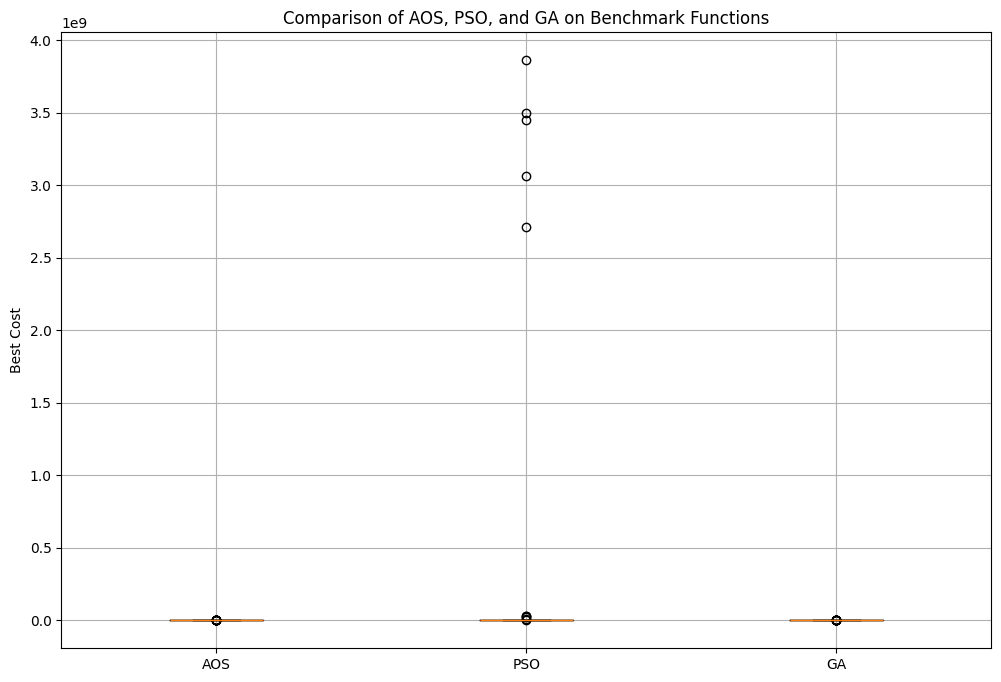

In [47]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.boxplot(results.values(), labels=results.keys())
plt.ylabel('Best Cost')
plt.title('Comparison of AOS, PSO, and GA on Benchmark Functions')
plt.grid(True)
plt.show()

### Statistical Analysis

#### Friedman Test

In [48]:
from scipy.stats import friedmanchisquare

# Perform the Friedman test
stat, p_value = friedmanchisquare(*results.values())

print(f"Friedman Test Statistic: {stat}")
print(f"P-Value: {p_value}")

Friedman Test Statistic: 43.309090909090855
P-Value: 3.940491553876183e-10


#### Wilcoxon Signed-Rank Test

In [49]:
from scipy.stats import wilcoxon

# Perform pairwise Wilcoxon signed-rank tests
for i, algo1 in enumerate(results.keys()):
    for j, algo2 in enumerate(results.keys()):
        if i < j:
            _, p_value = wilcoxon(results[algo1], results[algo2])
            print(f"Wilcoxon Test ({algo1} vs {algo2}): P-Value = {p_value}")

Wilcoxon Test (AOS vs PSO): P-Value = 0.0002273047837018321
Wilcoxon Test (AOS vs GA): P-Value = 1.658026421207076e-05
Wilcoxon Test (PSO vs GA): P-Value = 0.0002273047837018321


/var/folders/k8/pm7rdrpx1tx44znvg04hlryc0000gn/T/ipykernel_44937/2849048864.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys())


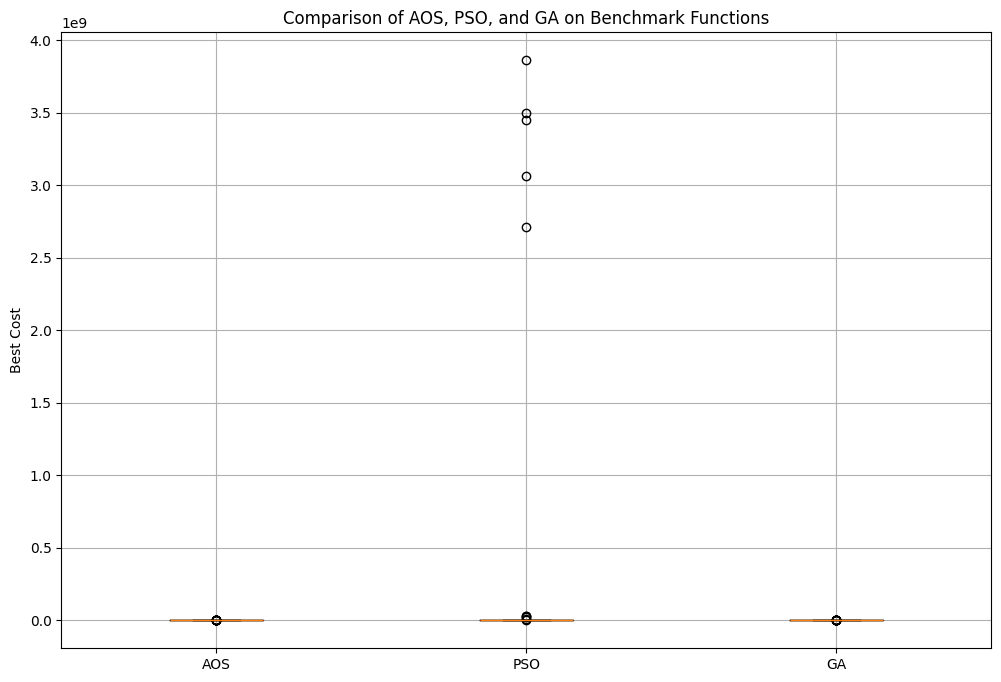

In [50]:
# Boxplots for visualizing the results

plt.figure(figsize=(12, 8))
plt.boxplot(results.values(), labels=results.keys())
plt.ylabel('Best Cost')
plt.title('Comparison of AOS, PSO, and GA on Benchmark Functions')
plt.grid(True)
plt.show()